# Make linear models regressing to OGTT AUC using only TGs

## Katie's idea was to see if summed TG quants can correlate with OGTT. 
### If they do, then the Wako trigylceride assay (https://us.vwr.com/store/product/18367215/l-type-triglyceride-m-assay-wako) would find similar information, and the assay could serve as a rapid indicator of a rat's diabetic status at a young age

### Make 4 pairs of models (fasted vs fed for all): 
1. TGs from all random-fed versus all fasted data, averaged within itself
2. All TGs averaged from week 8 
3. Week 9
4. Week 10

### Compare these models to only the top 10 "best" TGs (maybe the highly polyunsaturated TGs will be best)

In [263]:
import time
from collections import defaultdict
import json
import math

import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from models.data_subset_hyperparam_search import data_subset_hyperparam_search

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'  # https://stackoverflow.com/questions/34387893/output-matplotlib-figure-to-svg-with-text-as-text-not-curves
plt.style.use('seaborn-ticks')

import seaborn as sns
import dateutil
from scipy.stats import spearmanr, pearsonr, kendalltau
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, fcluster, fclusterdata

from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration
from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import (
    cross_val_score, cross_val_predict,
    RepeatedKFold, RepeatedStratifiedKFold,
    train_test_split, 
    GridSearchCV,
    LeaveOneGroupOut,
)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    classification_report,
    roc_auc_score, roc_curve, RocCurveDisplay, auc,
    confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay,
    f1_score, 
    recall_score,
    accuracy_score,
    precision_score, precision_recall_curve, precision_recall_fscore_support,
    #     plot_roc_curve,
    #     plot_precision_recall_curve,  ## The plot_x_score API is deprecated
)
import sklearn
print(sklearn.__version__)

1.0.2


In [137]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
# data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data = pd.read_csv(r'../data/processed/combined_metabolites_data.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

X_all = data[data_cols].T

# X_all = pd.DataFrame(StandardScaler().fit_transform(data[data_cols].T), index=data_cols, columns=data.index)

y_3class = fg['gluc_tol']                                                 # ['normal', 'impaired', 'diabetic']
y_3class_num = y_3class.map({'normal': 0, 'impaired': 1, 'diabetic': 2})  # [0, 1, 2]
y_bg = fg['bg']                                                           # random/fasted blood glucoose
y_ogtt = fg['animal'].map(ap['OGTT (AUC)'])
y_weight = fg['animal'].map(ap['Weightprefastweek12'])
y_insulin = fg['animal'].map(ap['Insulin (AUC)'])

### Compare top 10 TGs based on:
1. r2 * coef of linear model on random-fed data
2. q-value of OGTT 

In [407]:
# The top TG is the one with the best r2 and highest coefficient (steepest slope)
x = fg.loc[rbg_cols, 'ogtt'].values.reshape(-1, 1)

def linreg(x, y):
    lr = LinearRegression().fit(x, y)
    return lr.score(x, y), lr.coef_[0]

rdata = data.loc[data['molec_class'] == 'TG', rbg_cols].copy()
rdata['r2'], rdata['coef'] = zip(*rdata.apply(lambda quants: linreg(x=x, y=quants), axis=1))

rdata['abscoef'] = rdata['coef'].abs()
rdata['best'] = rdata['abscoef'] * rdata['r2']

top10_fits = rdata.sort_values('best', ascending=False)['best'].iloc[:10]
# display(data.loc[top10_fits.index, 'ID'])

# rdata['r2'].hist()
# plt.figure()
# rdata['coef'].hist()
# plt.figure()
# rdata.plot.scatter('r2', 'coef')

In [408]:
display(data.loc[top10_fits.index, 'ID'])
data.loc[top10_tg, 'ID']

i
l_538    TG 22:6_22:6_22:6
l_579             TG 62:13
l_525    TG 20:5_22:6_22:6
l_636    TG 18:0_20:5_22:6
l_567    TG 18:2_22:6_22:6
l_672             TG 60:10
l_608    TG 16:0_22:6_22:6
l_621             TG 58:10
l_559             TG 60:13
l_600    TG 18:2_18:2_22:6
Name: ID, dtype: object

i
l_538    TG 22:6_22:6_22:6
l_567    TG 18:2_22:6_22:6
l_672             TG 60:10
l_579             TG 62:13
l_619    TG 16:0_22:6_22:5
l_608    TG 16:0_22:6_22:6
l_604    TG 18:1_22:6_22:6
l_525    TG 20:5_22:6_22:6
l_636    TG 18:0_20:5_22:6
l_600    TG 18:2_18:2_22:6
Name: ID, dtype: object

In [396]:
def parse_lipid(lipid):
    l = lipid.split(' ')
    cls = l[0]
    fa = l[1]
    if '-' in fa:
        fa = fa.split('-')[1]
        label = fa.split('-')[0] + '-'
    else:
        label = ''
    if 'd' in fa:
        fa = fa.split('d')[1]
        label = fa.split('d')[0] + 'd'
    else:
        label = ''
        
    fa = [x.split(':') for x in fa.split('_')]
    fa = [[int(x) for x in sublist] for sublist in fa]
    carbons = sum([chain[0] for chain in fa])
    unsat = sum([chain[1] for chain in fa])
    sum_comp = str(carbons) + ':' + str(unsat)
    result = cls + ' ' + label + str(carbons) + ':' + str(unsat)
#     print(lipid, result)
    return cls, label, carbons, unsat, sum_comp, fa

In [520]:
def make_regplot(df, title='', ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))
    for bg_type in ['FBG', 'RBG']:
        sns.regplot(
            data=df.loc[df['bg_type'] == bg_type], 
    #         data=tg.loc[tg['bg_type'] == bg_type],
            x='ogtt', y='quant', 
            color=colors[bg_type], 
            n_boot=200,
    #         robust=True, n_boot=50,
    #         scatter=False,
            scatter_kws={'s': 60},
            ax=ax, seed=1,)
    min_ogtt, max_ogtt = ap.loc[ap['lcms_sampled'], 'OGTT (AUC)'].min(), ap.loc[ap['lcms_sampled'], 'OGTT (AUC)'].max()
    ax.set_xlim(min_ogtt - 1500, max_ogtt + 1500)
    ax.set_xticks(np.arange(20000, 60001, 10000), labels=['20k', '30k', '40k', '50k', '60k'], fontsize=14)
#     ax.set_xlabel('OGTT (AUC)', fontsize=15)
    ax.set_xlabel('OGTT (AUC)', fontsize=14)
#     ax.set_yticks(ticks=ax.get_yticks()[1:-1], labels=[str(int(x)) for x in ax.get_yticks()][1:-1],)                   fontsize=14)
#     ax.set_ylabel('log2 quantitation', fontsize=15)
    ax.set_ylabel('log2 quant.', fontsize=14)
    ax.set_yticks(ax.get_yticks(), labels=[str(int(x)) for x in ax.get_yticks()], fontsize=14)
    ax.set_title(title, fontsize=14)
    animal_ogtts = ap.loc[ap['lcms_sampled'], 'OGTT (AUC)']
    for animal_ogtt in animal_ogtts:
        ax.axvline(animal_ogtt, c='gray', linewidth=0.8, alpha=0.3, zorder=-10)
    sns.despine()
    return ax

In [571]:
tg

,quant,bg_type,ogtt,animal
1102_8_RBG,23.842725,RBG,46565.0,1102
1093_9_RBG,23.442414,RBG,25057.5,1093
1060_8_FBG,23.919615,FBG,48742.5,1060
1060_8_RBG,23.052786,RBG,48742.5,1060
1060_9_FBG,23.782127,FBG,48742.5,1060
1060_9_RBG,23.143178,RBG,48742.5,1060
1060_10_FBG,22.744311,FBG,48742.5,1060
1060_10_RBG,22.901676,RBG,48742.5,1060
1062_8_FBG,23.367628,FBG,43717.5,1062
1062_8_RBG,24.291447,RBG,43717.5,1062


<AxesSubplot:xlabel='OGTT (AUC)', ylabel='log2 quant.'>

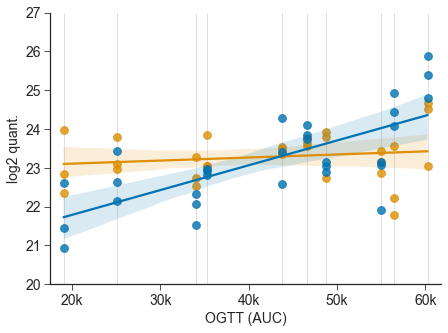

In [570]:
all_tgs = data.loc[data['molec_class'] == 'TG'].copy()
all_tgs['fa_carbons'], all_tgs['fa_unsat'], all_tgs['fa_carbon:unsat'] = \
    zip(*all_tgs.loc[:, 'ID'].apply(lambda x: parse_lipid(x)[2:5]))

tg = all_tgs.loc[:, data_cols] \
            .mean().to_frame(name='quant').join(fg[['bg_type', 'ogtt', 'animal']])
tg_top10 = all_tgs.sort_values('qval_ogtt').iloc[:10].loc[:, data_cols] \
                  .mean().to_frame(name='quant').join(fg[['bg_type', 'ogtt', 'animal']])

tg_saturated = all_tgs.loc[all_tgs['fa_unsat'] == 0, data_cols] \
                      .mean().to_frame(name='quant').join(fg[['bg_type', 'ogtt', 'animal']])
tg_monounsat = all_tgs.loc[all_tgs['fa_unsat'] == 1, data_cols] \
                      .mean().to_frame(name='quant').join(fg[['bg_type', 'ogtt', 'animal']])

top_tg = all_tgs.sort_values('pval_sampling:ogtt').iloc[0].name
top_tg_id = data.loc[top_tg, 'ID']
tg1 =  all_tgs.loc[top_tg, data_cols] \
              .astype('float').to_frame(name='quant').join(fg[['bg_type', 'ogtt', 'animal']])

tg_very_unsat = all_tgs.loc[all_tgs['fa_unsat'] > 9, data_cols] \
                       .mean().to_frame(name='quant').join(fg[['bg_type', 'ogtt', 'animal']])
tg_2_to_9_unsat = all_tgs.loc[(all_tgs['fa_unsat'] <= 9) & (all_tgs['fa_unsat'] >= 2), data_cols] \
                       .mean().to_frame(name='quant').join(fg[['bg_type', 'ogtt', 'animal']])

unsat_dfs = {}
for unsat_count, unsat_start, unsat_stop in [
    ('0-2 unsaturations', 0, 3),
    ('3-5 unsaturations', 3, 6),
    ('6-9 unsaturations', 6, 10),
    ('10-18 unsaturations', 10, 99),
]:
    df = all_tgs.loc[(all_tgs['fa_unsat'] >= unsat_start) & (all_tgs['fa_unsat'] < unsat_stop), data_cols] \
                .mean().to_frame(name='quant').join(fg[['bg_type', 'ogtt', 'animal']])
    unsat_dfs[unsat_count] = df

make_regplot(df=tg)

# TG 22:6_22:6_22:6 is not the best TG because it has such a low quant in normal rats (around log2 quant = 15)
## TG 18:2_22:6_22:6 is better because it starts around 19. 

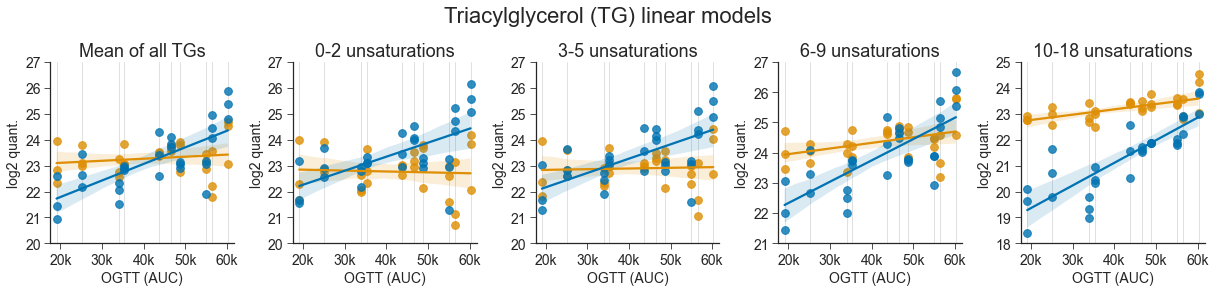

In [523]:
# subsets = [tg, tg10, tg1, tg_saturated, tg_monounsat]
# titles = ['Mean of all TGs', 'Mean of Top 10 TGs', f'Top TG\n({top_tg_id})', 
#           'Mean of\nsaturated TGs', 'Mean of\nmonounsaturated TGs']
subsets_titles = [
    (tg, 'Mean of all TGs'),
#     (tg10, 'Mean of Top 10 TGs\n(by p-value signif.)'),
#     (tg_saturated, 'Mean of\nsaturated TGs'),
#     (tg_monounsat, 'Mean of\nmonounsaturated TGs'),
#     (tg_2_to_9_unsat, 'Mean of TGs\nbetween 2 and 9 unsat.'),
#     (tg_very_unsat, 'Mean of TGs with\ntotal unsat. > 9'),
#     (tg1, f'Top TG\n({top_tg_id})'),
]
subsets_titles.extend([(value, key) for key, value in unsat_dfs.items()])

weeks = [
    ([8, 9, 10], 'All 3\nweeks'),
#     ([8], 'Week 8'), 
#     ([9], 'Week 9'),
#     ([10], 'Week 10'),
]

nrows = len(weeks)
ncols = len(subsets_titles)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey='col', figsize=(3*ncols+2, 2.1*nrows+2))
if nrows == 1:
    axs = [axs, ]
if ncols == 1:
    axs = [[ax, ] for ax in axs]
fig.suptitle('Triacylglycerol (TG) linear models', fontsize=22)
# fig.supxlabel('OGTT (AUC)', fontsize=20)
# fig.supylabel('Using\ndata\nfrom', fontsize=20, rotation=0)

for row, (week, week_title) in enumerate(weeks):
    for col, (subset, title) in enumerate(subsets_titles):
        ax = axs[row][col]
        make_regplot(df=subset.loc[fg['week'].isin(week)], ax=ax)
#         if col == 0:
#             ax.set_ylabel(week_title, fontsize=18, rotation=0, ha='right', fontweight='bold')
        if row == 0:
            ax.set_title(title, fontsize=18)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
plt.tight_layout()
# plt.savefig('../reports/figures/TG_linear_models/TG_allweeks_unsatsasdf.svg', dpi=150, bbox_inches='tight')
# plt.savefig('../reports/figures/TG_linear_models/TG_allweeks_unsatsasdf.png', dpi=150, bbox_inches='tight')

In [430]:
# top_tg = top10_tg[0]
# top_tg_id = data.loc[top_tg, 'ID']
# tg1 =  data.loc[top_tg, data_cols] \
#            .astype('float') \
#            .to_frame(name='quant') \
#            .join(fg[['bg_type', 'ogtt', 'animal']])

# fig, ((a1, a2, a3), (a4, a5, a6), (a7, a8, a9), (a10, a11, a12)) = plt.subplots(
#     nrows=4, ncols=3, sharex=True, sharey='col', figsize=(14, 11))
# fig.suptitle('Triacylglycerol (TG) linear models', fontsize=22)
# fig.supxlabel('OGTT (AUC)', fontsize=20)
# fig.supylabel('Using\ndata\nfrom', fontsize=20, rotation=0)

# make_regplot(df=tg,                         ax=a1)  # title='Mean all TG',   
# make_regplot(df=tg.loc[fg['week'] == 8],    ax=a4)  # title='Mean all TG',   
# make_regplot(df=tg.loc[fg['week'] == 9],    ax=a7)  # title='Mean all TG',   
# make_regplot(df=tg.loc[fg['week'] == 10],   ax=a10)  # title='Mean all TG',   
# make_regplot(df=tg10,                       ax=a2)  # title='Mean top 10 TG',
# make_regplot(df=tg10.loc[fg['week'] == 8],  ax=a5)  # title='Mean top 10 TG',
# make_regplot(df=tg10.loc[fg['week'] == 9],  ax=a8)  # title='Mean top 10 TG',
# make_regplot(df=tg10.loc[fg['week'] == 10], ax=a11)  # title='Mean top 10 TG',
# make_regplot(df=tg1,                        ax=a3) 
# make_regplot(df=tg1.loc[fg['week'] == 8],   ax=a6) 
# make_regplot(df=tg1.loc[fg['week'] == 9],   ax=a9) 
# make_regplot(df=tg1.loc[fg['week'] == 10],  ax=a12)

# for ax, week in zip([a1, a4, a7, a10], ['All\nweeks', 'Week 8', 'Week 9', 'Week 10']):
#     ax.set_ylabel(week, fontsize=18, rotation=0, ha='right', fontweight='bold')
# a1.set_title('Mean of all TGs', fontsize=18)
# a2.set_title('Mean of Top 10 TGs', fontsize=18)
# a3.set_title(f'Top TG\n({top_tg_id})', fontsize=18)

# plt.tight_layout()

# plt.savefig('../reports/figures/TG_linear_models/TG_asdf.png', dpi=100, facecolor='white', bbox_inches='tight')

In [467]:
d = data.loc[:, data_cols].T.join(fg['bg_type'])
d['x'] = d['bg_type'].map({'RBG': 0, 'FBG': 1})
d

,m_0,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_9,m_10,...,l_865,l_866,l_867,l_868,l_869,l_870,l_871,l_872,bg_type,x
1102_8_RBG,16.861652,22.144573,22.576981,23.803795,24.596731,23.371599,22.847897,23.547123,22.996484,22.784077,...,19.400819,20.144070,20.512869,20.930734,19.535142,18.104875,17.878105,16.200014,RBG,0
1093_9_RBG,16.671317,20.963399,23.843259,24.316310,26.201371,23.332309,23.054384,23.325673,23.245015,22.410160,...,18.916621,20.310619,19.845454,20.351041,19.313450,18.387917,17.974406,15.915763,RBG,0
1060_8_FBG,17.594730,20.198771,23.895235,24.714910,17.148994,22.653452,22.084504,21.397206,22.065355,21.679060,...,18.623483,20.648780,20.005141,20.999142,19.774817,20.517490,20.603688,19.836798,FBG,1
1060_8_RBG,20.826956,21.959743,23.754788,24.235682,17.431244,23.211817,22.667628,22.998237,22.896178,22.468343,...,18.212006,20.310682,19.423127,20.589383,18.430226,17.921098,17.488155,16.202162,RBG,0
1060_9_FBG,21.809716,20.524661,24.263211,24.520405,19.169210,23.207043,22.450039,21.424020,22.534742,21.849560,...,18.782562,20.389699,19.797970,21.377454,20.184092,20.671826,20.788152,20.234283,FBG,1
1060_9_RBG,22.730565,21.240594,19.532128,23.866956,26.312933,23.109947,22.595668,22.956542,22.718984,22.285428,...,18.340561,19.661018,19.568500,20.581856,18.948519,18.261890,17.718258,16.494586,RBG,0
1060_10_FBG,18.748109,20.303969,23.084387,24.792384,27.209158,22.793616,22.563256,21.784634,22.664376,21.631447,...,15.798292,16.197032,17.768934,20.033965,17.930418,19.568571,19.769735,19.279616,FBG,1
1060_10_RBG,18.990099,22.020890,23.528259,23.998058,25.956118,23.454379,22.935395,23.571467,23.056140,22.479336,...,17.826820,19.299064,19.066750,20.209183,18.440239,17.211559,17.016673,15.240250,RBG,0
1062_8_FBG,18.098242,21.019048,24.873347,24.787384,21.774699,23.221875,22.352220,21.964129,22.346725,22.098343,...,16.652292,17.166214,17.882779,19.507955,17.567143,19.348489,19.240306,18.585339,FBG,1
1062_8_RBG,18.060936,22.271482,23.321162,23.858506,26.822243,23.272693,23.005211,23.224943,23.180628,22.833888,...,19.550020,21.079083,20.569204,21.008095,19.595734,18.996482,18.778798,16.471090,RBG,0


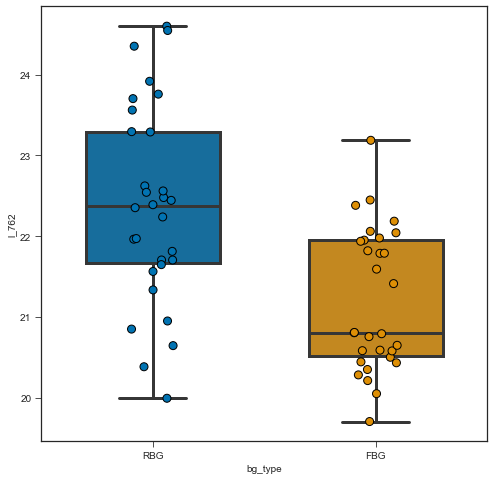

In [492]:
sns.boxplot(data=d,   y='l_762', x='bg_type', width=0.6, palette=colors, linewidth=3)
sns.stripplot(data=d,   y='l_762', x='bg_type', palette=colors, s=8, edgecolor='black', linewidth=1)
plt.gcf().set_size_inches(8, 8)

In [491]:
data.loc['l_762']

unique_id             TG 18:1_18:0_22:5_17.462_952.83173
RT                                                17.462
m/z                                            952.83173
adduct                                               NaN
Type                                               lipid
                                     ...                
qval_ogtt                                       0.000664
qval_sampling:ogtt                              0.184613
pval_sampling                                   0.000009
pval_ogtt                                       0.000104
pval_sampling:ogtt                               0.09689
Name: l_762, Length: 74, dtype: object

In [539]:
weekdf

,l_762,bg_type,week,ogtt
1102_8_RBG,23.702199,RBG,8,46565.0
1093_9_RBG,22.478916,RBG,9,25057.5
1060_8_FBG,21.820736,FBG,8,48742.5
1060_8_RBG,22.443769,RBG,8,48742.5
1060_9_FBG,21.414508,FBG,9,48742.5
1060_9_RBG,22.560387,RBG,9,48742.5
1060_10_FBG,20.446709,FBG,10,48742.5
1060_10_RBG,21.706539,RBG,10,48742.5
1062_8_FBG,22.061042,FBG,8,43717.5
1062_8_RBG,23.293747,RBG,8,43717.5


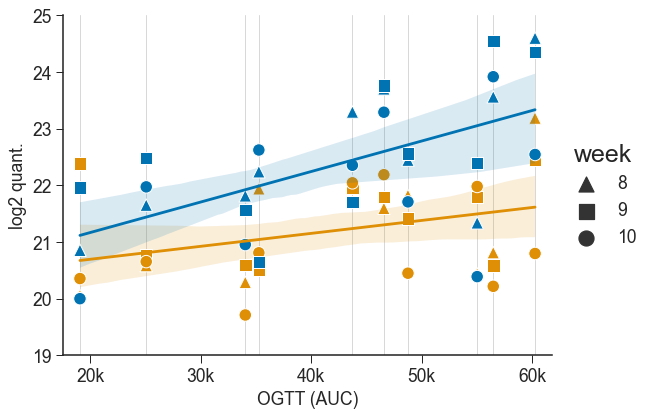

In [568]:
feature = 'l_762'
weekdf = data.loc[feature, data_cols].to_frame().join(fg[['bg_type', 'week', 'ogtt']])
weekdf[feature] = weekdf[feature].astype('float')
weekdf['week'] = weekdf['week'].astype('str')

fig, ax = plt.subplots(figsize=(7, 5), dpi=90)
for bg_type in ['FBG', 'RBG']:
    sns.regplot(
        data=weekdf.loc[weekdf['bg_type'] == bg_type], 
#         data=tg.loc[tg['bg_type'] == bg_type],
        x='ogtt', y=feature, 
        color=colors[bg_type], 
        n_boot=200,
#         robust=True, n_boot=50,
        scatter=False,
        scatter_kws={'s': 60},
        ax=ax, seed=1,)
    sns.scatterplot(
        data=weekdf.loc[weekdf['bg_type'] == bg_type], x='ogtt', y=feature,
        color=colors[bg_type], style='week', markers={'8':'^', '9':'s', '10':'o'}, 
        legend=(True if bg_type == 'RBG' else False),
        s=100,
    )
min_ogtt, max_ogtt = ap.loc[ap['lcms_sampled'], 'OGTT (AUC)'].min(), ap.loc[ap['lcms_sampled'], 'OGTT (AUC)'].max()
ax.set_xlim(min_ogtt - 1500, max_ogtt + 1500)
ax.set_xticks(np.arange(20000, 60001, 10000), labels=['20k', '30k', '40k', '50k', '60k'], fontsize=14)
#     ax.set_xlabel('OGTT (AUC)', fontsize=15)
ax.set_xlabel('OGTT (AUC)', fontsize=14)
#     ax.set_yticks(ticks=ax.get_yticks()[1:-1], labels=[str(int(x)) for x in ax.get_yticks()][1:-1],)                   fontsize=14)
#     ax.set_ylabel('log2 quantitation', fontsize=15)
ax.set_ylabel('log2 quant.', fontsize=14)
ax.set_yticks(ax.get_yticks(), labels=[str(int(x)) for x in ax.get_yticks()], fontsize=14)
# ax.set_title(title, fontsize=14)
animal_ogtts = ap.loc[ap['lcms_sampled'], 'OGTT (AUC)']
for animal_ogtt in animal_ogtts:
    ax.axvline(animal_ogtt, c='gray', linewidth=0.8, alpha=0.3, zorder=-10)
plt.legend(loc=(1.02, 0.3), fontsize=14, markerscale=2, title='week', title_fontsize=20)
sns.despine()